<a href="https://colab.research.google.com/github/fAikoH-dot/TCC-v1/blob/main/arima/auto_arima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

In [2]:
# df = pd.read_csv("sample_data/Trigo_v1.csv", sep = ";")
df = pd.read_csv('../../data library/Trigo_v1.csv', sep=";")
df = df.sort_values(by='Data').reset_index(drop=True)
# df.set_index("Data", inplace = True)
df.head()

,Data,Cultivo,Estadual,País,Id,Último,Abertura,Máxima,Mínima
0,2004-03-01,Trigo,25.0014,24.2907,2,38150.0,40825.0,42400.0,36600.0
1,2004-04-01,Trigo,27.3438,26.4508,2,36200.0,38050.0,40700.0,35400.0
2,2004-05-01,Trigo,29.6849,28.6268,2,33800.0,36500.0,39100.0,0.0
3,2004-06-01,Trigo,30.2614,29.9106,2,31225.0,33525.0,34800.0,31000.0
4,2004-07-01,Trigo,27.5388,27.7931,2,30975.0,31075.0,32400.0,29550.0


In [3]:
%pip install python-bcb

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
from bcb import PTAX
from bcb import currency

ptax = PTAX()

df_usd = currency.get(['USD'],
                  start='2004-03-01',
                  end='2024-09-01',
                  side='ask')

df_usd["Date"]=df_usd.index
df_usd["Month"] = df_usd["Date"].dt.month
df_usd["Year"] = df_usd["Date"].dt.year
df_usd["Day"] = 1
df_usd["Aux"] = df_usd["Year"].astype(str) +"-"+ df_usd["Month"].astype(str)
df_usd = df_usd.groupby("Aux").agg(
    USD = ("USD", "mean"),
    day = ("Day", "first"),
    month = ("Month", "first"),
    year = ("Year", "first"),
).reset_index(drop=True)

df_usd["Data"] = pd.to_datetime(df_usd[['year', 'month', 'day']])
df_usd = df_usd[["Data", "USD"]].sort_values(by="Data").reset_index(drop=True)

In [5]:
# clima = pd.read_csv("sample_data/MT_dados.csv", sep=';')
clima = pd.read_csv("../../data library/Clima/MT_dados.csv", sep=';')
clima.rename(columns={"PRECIPITACAO TOTAL":"precipitacao", "TEMPERATURA MEDIA":"temperatura"}, inplace=True)

clima["precipitacao"] = clima.precipitacao.str.replace(',', '.')
clima["temperatura"] = clima.temperatura.str.replace(',', '.')

clima.bfill(inplace=True)
clima.head()

,Data Medicao,precipitacao,temperatura
0,31/03/2004,175.4,24.9
1,30/04/2004,175.4,24.5
2,31/05/2004,23,21.7
3,30/06/2004,18.8,22.1
4,31/07/2004,38,22.2


In [6]:
df["USD"] = df_usd["USD"]
df["Precipitacao"] = clima["precipitacao"].astype(float)
df["Temperatura"] = clima["temperatura"].astype(float)
df['lag_Estadual'] = df['Estadual'].shift(1)
df['lag_Estadual'] = df['lag_Estadual'].bfill()
df.head()

,Data,Cultivo,Estadual,País,Id,Último,Abertura,Máxima,Mínima,USD,Precipitacao,Temperatura,lag_Estadual
0,2004-03-01,Trigo,25.0014,24.2907,2,38150.0,40825.0,42400.0,36600.0,2.905457,175.4,24.9,25.0014
1,2004-04-01,Trigo,27.3438,26.4508,2,36200.0,38050.0,40700.0,35400.0,2.905985,175.4,24.5,25.0014
2,2004-05-01,Trigo,29.6849,28.6268,2,33800.0,36500.0,39100.0,0.0,3.100419,23.0,21.7,27.3438
3,2004-06-01,Trigo,30.2614,29.9106,2,31225.0,33525.0,34800.0,31000.0,3.129148,18.8,22.1,29.6849
4,2004-07-01,Trigo,27.5388,27.7931,2,30975.0,31075.0,32400.0,29550.0,3.036777,38.0,22.2,30.2614


In [7]:
%pip install pmdarima

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.




[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

from pmdarima.arima import auto_arima
from pmdarima import arima
from pmdarima.utils import tsdisplay, autocorr_plot, decomposed_plot, plot_acf, plot_pacf
from matplotlib.pyplot import rcParams

rcParams['figure.figsize']=15,6

from pmdarima.arima import ADFTest
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [8]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error

In [9]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series, signif=0.05, name='', verbose=False):


    result = adfuller(series.values)
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

def plot_predictions(testing_dates, y_test, prediction):
    df_test = pd.DataFrame({"date": testing_dates, "actual": y_test, "prediction": prediction })
    _, ax = plt.subplots(figsize=(10, 5))
    df_test.plot(ax=ax, label="Actual", x="date", y="actual")
    df_test.plot(ax=ax, label="Prediction", x="date", y="prediction")
    plt.legend(["Actual", "Prediction"])
    plt.show()

In [10]:
def evaluate_model(y_test, prediction):
  print(f"MAE: {mean_absolute_error(y_test, prediction)}")
  print(f"RMSE: {root_mean_squared_error(y_test, prediction)}")
  print(f"MAPE: {mean_absolute_percentage_error(y_test, prediction)}")
  print(f"R-Squared: {r2_score(y_test, prediction)}")

In [11]:
train_size = int(len(df) * 0.8)
train, test = df[0:train_size], df[train_size:len(df)]

check_stationarity(train["Estadual"], name=train["Estadual"].name)

    Augmented Dickey-Fuller Test on "Estadual" 
    -----------------------------------------------
ADF Statistic: -0.810060
p-value: 0.816149
Critical Values:
	1%: -3.465
	5%: -2.877
	10%: -2.575
Non-stationary


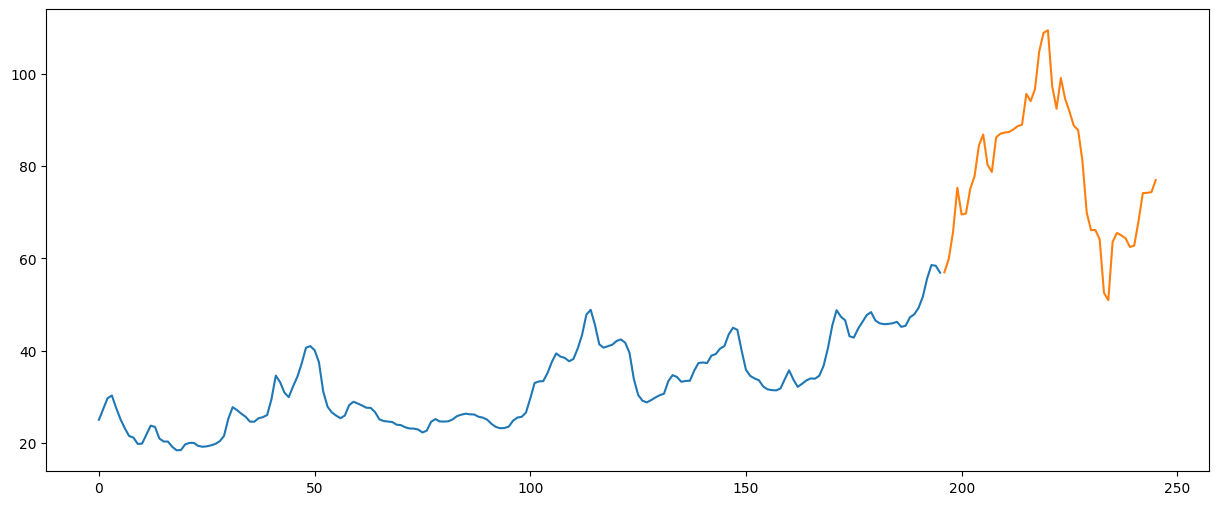

In [12]:
train_size = int(len(df) * 0.8)
train, test = df[0:train_size], df[train_size:len(df)]

test_dates = test.Data

# train = train.Estadual
# test = test.Estadual

plt.plot(train.Estadual)
plt.plot(test.Estadual)

In [13]:
from pmdarima.arima import ADFTest

adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(df["Estadual"])

##Dado Não-Estacionário > I = 0

(0.36955482090099556, True)

In [14]:
train.head()

,Data,Cultivo,Estadual,País,Id,Último,Abertura,Máxima,Mínima,USD,Precipitacao,Temperatura,lag_Estadual
0,2004-03-01,Trigo,25.0014,24.2907,2,38150.0,40825.0,42400.0,36600.0,2.905457,175.4,24.9,25.0014
1,2004-04-01,Trigo,27.3438,26.4508,2,36200.0,38050.0,40700.0,35400.0,2.905985,175.4,24.5,25.0014
2,2004-05-01,Trigo,29.6849,28.6268,2,33800.0,36500.0,39100.0,0.0,3.100419,23.0,21.7,27.3438
3,2004-06-01,Trigo,30.2614,29.9106,2,31225.0,33525.0,34800.0,31000.0,3.129148,18.8,22.1,29.6849
4,2004-07-01,Trigo,27.5388,27.7931,2,30975.0,31075.0,32400.0,29550.0,3.036777,38.0,22.2,30.2614


# USD

In [16]:
train_size = int(len(df) * 0.8)
train, test = df[0:train_size], df[train_size:len(df)]

test_dates = test.Data

In [17]:
arima_model = auto_arima(train.Estadual, X = train[["USD", "País"]],start_p=0, d=0, start_q=0,
                         max_p = 5, max_d = 5, max_q = 5,
                         start_P = 0, D = 0, start_Q=5,
                         max_P=5, max_D=5, max_Q=5,
                         m=12, seasonal=True, error_action ="warn",
                         Trace=True, random_state=20, n_fits=50)

In [20]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  202
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -317.335
Date:                Mon, 07 Apr 2025   AIC                            644.669
Time:                        00:23:28   BIC                            661.211
Sample:                             0   HQIC                           651.362
                                - 202                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3281      0.159      2.058      0.040       0.016       0.641
USD            2.0775      0.611      3.400      0.001       0.880       3.275
País           0.7635      0.030     25.245      0.000       0.704       0.823
ar.L1          0.9128      0.016     56.534      0.000       0.881       0.944
sigma2         1.3434      0.096     13.990      0.000       1.155       1.532
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              2789.04
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.44   Skew:                            -0.89
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
prediction = pd.DataFrame(arima_model.predict(n_periods=len(test), X=test[["USD", "País"]]),
                          # index=test.index
                          )
prediction.columns = ["predicted_Estadual"]
prediction.index = test.index

ValueError: Found non-finite values in dataframe

<ipython-input-23-c44d8dde0550>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Data"] = test.index


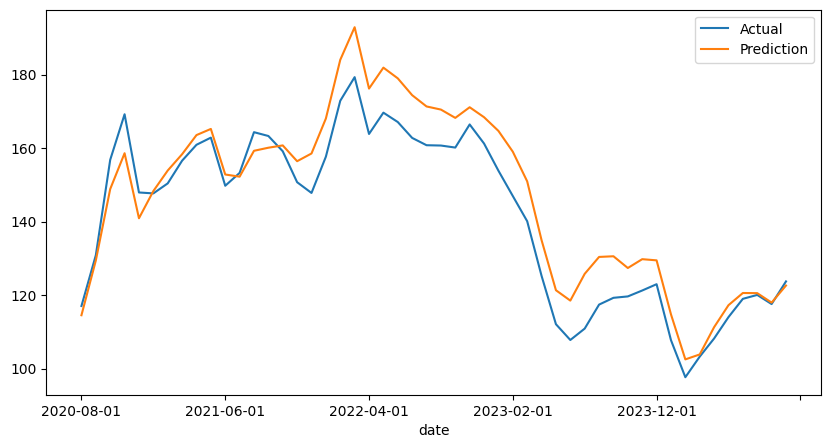

In [ ]:
test["Data"] = test.index
testing_dates = test_dates

plot_predictions(testing_dates, test.Estadual, prediction.predicted_Estadual)

In [ ]:
test = pd.DataFrame(test)
test["predict_Estadual"] = prediction['predicted_Estadual']
test.head()

,Data,Cultivo,Estadual,País,Id,Último,Abertura,Máxima,Mínima,USD,Precipitacao,Temperatura,lag_Estadual,predict_Estadual
196,196,Soja,117.0222,113.3375,0,95250.00000,89175.00000,96688.00000,86538.00000,5.280191,33.0,26.7,104.0607,114.511640
197,197,Soja,130.8449,128.3004,0,1.02175,95062.00000,1.04650,94288.00000,5.461233,33.0,26.7,117.0222,129.417034
198,198,Soja,156.7972,147.4121,0,1.05688,1.02338,1.09388,1.01300,5.399486,33.0,26.7,130.8449,148.846007
199,199,Soja,169.1946,157.3982,0,1.16875,1.06025,1.19962,1.04162,5.625790,33.0,26.7,156.7972,158.592977
200,200,Soja,147.9145,140.9301,0,1.31025,1.16962,1.32060,1.14262,5.417835,33.0,26.7,169.1946,140.897886


In [ ]:
evaluate_model(test["Estadual"], test["predict_Estadual"])

MAE: 6.839740734014266
RMSE: 8.079860711872838
MAPE: 0.048617990048654025
R-Squared: 0.8728950563109299


# Multiple Variables

In [18]:
train_size = int(len(df) * 0.8)
train, test = df[0:train_size], df[train_size:len(df)]

test_dates = test.Data

In [19]:
arima_model = auto_arima(train.Estadual, X = train[["USD", "País", "Último", "Máxima", "Precipitacao", "lag_Estadual"]],start_p=0, d=0, start_q=0,
                         max_p = 5, max_d = 5, max_q = 5,
                         start_P = 0, D = 0, start_Q=5,
                         max_P=5, max_D=5, max_Q=5,
                         m=12, seasonal=True, error_action ="warn",
                         Trace=True, random_state=20, n_fits=50)

C:\Users\hamatsu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


In [20]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  196
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -295.416
Date:                Thu, 10 Apr 2025   AIC                            606.831
Time:                        11:44:57   BIC                            633.056
Sample:                             0   HQIC                           617.448
                                - 196                                         
Covariance Type:                  opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
USD             -0.5127      0.362     -1.417      0.157      -1.222       0.197
País             0.6595      0.040     16.427      0.000       0.581       0.738
Último       -3.341e-06   1.31e-05     -0.256      0.798   -2.89e-05    2.22e-05
Máxima        -1.06e-05   7.11e-06     -1.491      0.136   -2.45e-05    3.33e-06
Precipitacao    -0.0004      0.001     -0.311      0.756      -0.003       0.002
lag_Estadual     0.4576      0.028     16.171      0.000       0.402       0.513
ar.L1            0.5674      0.047     11.991      0.000       0.475       0.660
sigma2           1.1965      0.105     11.411      0.000       0.991       1.402
===================================================================================
Ljung-Box (L1) (Q):                   0.56   Jarque-Bera (JB):              1035.00
Prob(Q):                              0.45   Prob(JB):                         0.00
Heteroskedasticity (H):               0.57   Skew:                            -1.55
Prob(H) (two-sided):                  0.02   Kurtosis:                        13.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
# Import required libraries

import pandas as pd
import numpy as np

# Create dataframe using dictionary
data_aux = test.copy()

df_aux = pd.DataFrame(data_aux)

# Replace infinite updated data with nan
df_aux.replace([np.inf, -np.inf], np.nan, inplace=True)

df_aux.ffill(inplace=True)

test = df_aux.copy()

In [22]:
prediction = pd.DataFrame(arima_model.predict(n_periods=len(test), X=test[["USD", "País", "Último", "Máxima", "Precipitacao", "lag_Estadual"]]),
                          # index=test.index
                          )
prediction.columns = ["predicted_Estadual"]
prediction.index = test.index

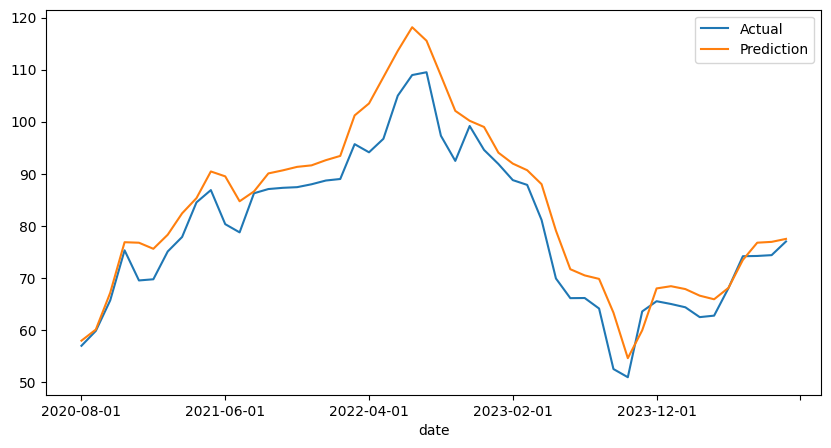

In [23]:
test["Data"] = test.index
testing_dates = test_dates

plot_predictions(testing_dates, test.Estadual, prediction.predicted_Estadual)

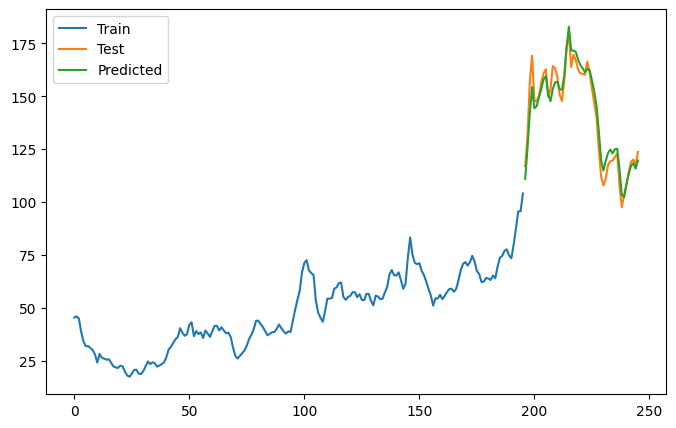

In [41]:
plt.figure(figsize=(8,5))
plt.plot(train.Estadual, label = "Train")
plt.plot(test.Estadual, label = "Test")
plt.plot(prediction, label = "Predicted")
plt.legend(loc='upper left')
plt.show()

In [24]:
test = pd.DataFrame(test)
test["predict_Estadual"] = prediction['predicted_Estadual']
test.head()

,Data,Cultivo,Estadual,País,Id,Último,Abertura,Máxima,Mínima,USD,Precipitacao,Temperatura,lag_Estadual,predict_Estadual
196,196,Trigo,56.9863,56.1960,2,54650.0,52612.0,55175.0,48812.0,5.280191,33.0,26.7,56.9056,57.970228
197,197,Trigo,59.8474,58.5133,2,57812.0,54188.0,58662.0,53338.0,5.461233,33.0,26.7,56.9863,60.104380
198,198,Trigo,65.6995,66.6685,2,59850.0,57512.0,63762.0,56138.0,5.399486,33.0,26.7,59.8474,67.165086
199,199,Trigo,75.3144,77.1260,2,58100.0,59675.0,62588.0,57950.0,5.625790,33.0,26.7,65.6995,76.870027
200,200,Trigo,69.5309,70.0093,2,64175.0,57938.0,64438.0,56350.0,5.417835,33.0,26.7,75.3144,76.772363


In [25]:
output_arima = pd.concat([train, test], ignore_index=True)
output_arima["model"] = "ARIMA"
output_arima.to_csv("Trigo_Resultados_ARIMA.csv", index=False, sep=',')

In [43]:
evaluate_model(test["Estadual"], test["predict_Estadual"])

MAE: 4.424606110083662
RMSE: 5.47067492606383
MAPE: 0.03210967260751286
R-Squared: 0.9417311411382636


Não-estacionário para Estacionário


In [15]:
teste = pd.Series(df["Estadual"], name="Estadual")
teste.describe()

count    246.000000
mean      41.939987
std       21.574414
min       18.379500
25%       25.688300
50%       34.122250
75%       47.626150
max      109.498000
Name: Estadual, dtype: float64

In [16]:
df = pd.read_csv("../../data library/Trigo_v1.csv", sep = ";")
df = df.sort_values(by='Data').reset_index(drop=True)
# df.set_index("Data", inplace = True)
df.head()

,Data,Cultivo,Estadual,País,Id,Último,Abertura,Máxima,Mínima
0,2004-03-01,Trigo,25.0014,24.2907,2,38150.0,40825.0,42400.0,36600.0
1,2004-04-01,Trigo,27.3438,26.4508,2,36200.0,38050.0,40700.0,35400.0
2,2004-05-01,Trigo,29.6849,28.6268,2,33800.0,36500.0,39100.0,0.0
3,2004-06-01,Trigo,30.2614,29.9106,2,31225.0,33525.0,34800.0,31000.0
4,2004-07-01,Trigo,27.5388,27.7931,2,30975.0,31075.0,32400.0,29550.0


In [17]:
df['Data'] = pd.to_datetime(df['Data'])
df["USD"] = df_usd["USD"]
df = df.set_index('Data')
monthly_summary = df.Estadual.resample('ME').mean().ffill()

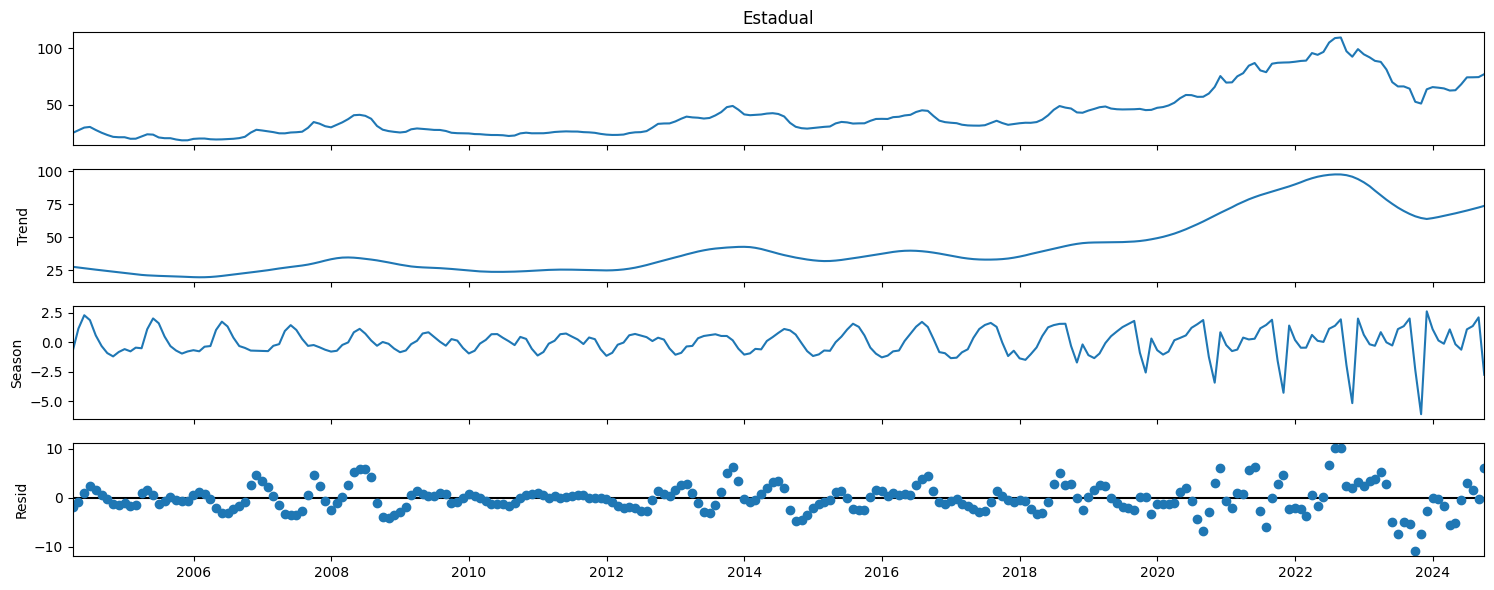

In [18]:
from statsmodels.tsa.seasonal import STL

stl = STL(monthly_summary, seasonal=13)
res = stl.fit()
fig = res.plot()

In [19]:
#Aplicanto a função Log para converter os dados para estacionários

df_log=np.sqrt(df['Estadual'])
df_diff=df_log.diff().dropna()

In [20]:
# from pmdarima.arima import ADFTest

# adf_test = ADFTest(alpha = 0.05)
# adf_test.should_diff(df_diff)

##Dado Estacionário > I = 1

check_stationarity(df_diff, name=df_diff.name)

    Augmented Dickey-Fuller Test on "Estadual" 
    -----------------------------------------------
ADF Statistic: -4.628476
p-value: 0.000114
Critical Values:
	1%: -3.459
	5%: -2.874
	10%: -2.573
Stationary


In [21]:
df["Estadual"] = df_diff
df = df.bfill()
df.head()

,Cultivo,Estadual,País,Id,Último,Abertura,Máxima,Mínima,USD
Data,,,,,,,,,
2004-03-01,Trigo,0.228990,24.2907,2,38150.0,40825.0,42400.0,36600.0,2.905457
2004-04-01,Trigo,0.228990,26.4508,2,36200.0,38050.0,40700.0,35400.0,2.905985
2004-05-01,Trigo,0.219255,28.6268,2,33800.0,36500.0,39100.0,0.0,3.100419
2004-06-01,Trigo,0.052651,29.9106,2,31225.0,33525.0,34800.0,31000.0,3.129148
2004-07-01,Trigo,-0.253294,27.7931,2,30975.0,31075.0,32400.0,29550.0,3.036777


In [22]:
train_size = int(len(df.Estadual.dropna()) * 0.75)

train, test = df[0:train_size], df[train_size:len(df)]
# train, test = df.Estadual.dropna()[0:size], df.Estadual.dropna()[size:len(df.Estadual.dropna())]
# test = test.reset_index()['Estadual']
history = [x for x in train.Estadual]
predictions = []

In [23]:
arima_model = auto_arima(train.Estadual, X = train[["USD", "País"]], start_p=0, d=1, start_q=0,
                         max_p = 5, max_d = 5, max_q = 5,
                         start_P = 0, D = 1, start_Q=5,
                         max_P=5, max_D=5, max_Q=5,
                         m=13, seasonal=True, error_action ="warn",
                         Trace=True, random_state=20, n_fits=50)

In [24]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  184
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 13)   Log Likelihood                  91.075
Date:                            Thu, 15 May 2025   AIC                           -170.150
Time:                                    12:38:14   BIC                           -151.335
Sample:                                         0   HQIC                          -162.515
                                            - 184                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
USD            0.1799      0.094      1.924      0.054      -0.003       0.363
País           0.0102      0.005      1.893      0.058      -0.000       0.021
ar.L1         -0.3925      0.363     -1.082      0.279      -1.103       0.318
ma.L1          0.5701      0.305      1.872      0.061      -0.027       1.167
ma.S.L13      -0.8695      0.090     -9.612      0.000      -1.047      -0.692
sigma2         0.0180      0.002      9.424      0.000       0.014       0.022
===================================================================================
Ljung-Box (L1) (Q):                   0.39   Jarque-Bera (JB):                 8.63
Prob(Q):                              0.53   Prob(JB):                         0.01
Heteroskedasticity (H):               0.67   Skew:                            -0.27
Prob(H) (two-sided):                  0.14   Kurtosis:                         3.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
prediction = pd.DataFrame(arima_model.predict(n_periods=len(test), X = test[["USD", "País"]]),
                          # index=test.index
                          )
prediction.columns = ["predicted_Estadual"]
prediction.index = test.index
prediction

C:\Users\hamatsu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\hamatsu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


,predicted_Estadual
Data,
2019-08-01,0.010915
2019-09-01,-0.014254
2019-10-01,-0.040522
2019-11-01,-0.128186
2019-12-01,-0.071161
...,...
2024-05-01,0.130008
2024-06-01,0.218633
2024-07-01,0.292105


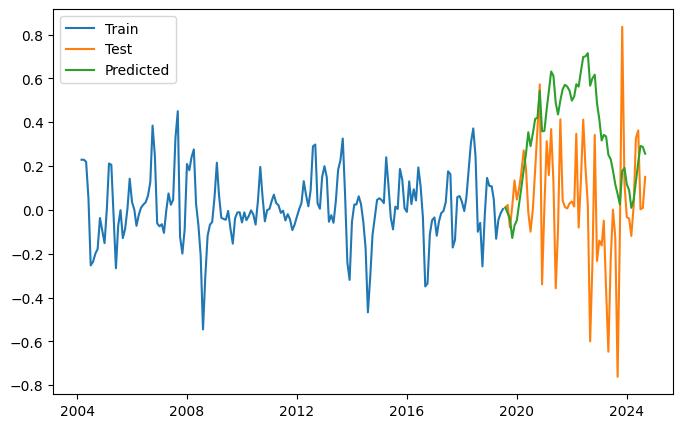

In [26]:
plt.figure(figsize=(8,5))
plt.plot(train.Estadual, label = "Train")
plt.plot(test.Estadual, label = "Test")
plt.plot(prediction, label = "Predicted")
plt.legend(loc='upper left')
plt.show()

In [27]:
test = pd.DataFrame(test)
test["predict_Estadual"] = prediction['predicted_Estadual']
test

,Cultivo,Estadual,País,Id,Último,Abertura,Máxima,Mínima,USD,predict_Estadual
Data,,,,,,,,,,
2019-08-01,Trigo,0.010070,42.3947,2,46138.0,48700.0,50538.0,45625.0,3.779339,0.010915
2019-09-01,Trigo,0.022781,42.5980,2,49550.0,46188.0,50088.0,45062.0,4.019982,-0.014254
2019-10-01,Trigo,-0.080059,40.4704,2,50875.0,49625.0,53488.0,48538.0,4.121500,-0.040522
2019-11-01,Trigo,0.016386,39.8819,2,54212.0,50850.0,54588.0,49862.0,4.086987,-0.128186
2019-12-01,Trigo,0.134385,41.2625,2,55938.0,54238.0,56462.0,51638.0,4.155345,-0.071161
...,...,...,...,...,...,...,...,...,...,...
2024-05-01,Trigo,0.327202,65.2951,2,69950.0,60425.0,73925.0,59350.0,5.129095,0.130008
2024-06-01,Trigo,0.362564,69.6117,2,55350.0,67800.0,69775.0,53800.0,5.133048,0.218633
2024-07-01,Trigo,0.002978,70.3762,2,52725.0,55650.0,57300.0,51425.0,5.388975,0.292105


In [28]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error

In [29]:
def evaluate_model(y_test, prediction):
  print(f"MAE: {mean_absolute_error(y_test, prediction)}")
  print(f"RMSE: {root_mean_squared_error(y_test, prediction)}")
  print(f"MAPE: {mean_absolute_percentage_error(y_test, prediction)}")
  print(f"R-Squared: {r2_score(y_test, prediction)}")

In [30]:
evaluate_model(test["Estadual"], test["predict_Estadual"])

MAE: 0.35500608516180704
RMSE: 0.44313622863529545
MAPE: 11.316705760474878
R-Squared: -1.6920685187756654
